In [56]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

In [117]:
# Deafening
z2_raw = loadmat('data_from_Fabiola/zscore_deafening.mat')
z_predeaf, z_postdeaf = z2_raw['zscore_pre'][:,0], z2_raw['zscore_post'][:,0]

In [118]:
# White Noise Perturbation
# z1_raw = loadmat('data_from_Fabiola/zscore_song.mat')
# z_correct, z_pert = z1_raw['zscore_song'], z1_raw['zscore_songwn'] # less data
z_correct = loadmat('data_from_Fabiola/mean_mat.mat')['mean_mat']
z_pert = loadmat('data_from_Fabiola/mean_mat2.mat')['mean_mat2']
z_correct = (z_correct - z_correct[:,54:60].mean(axis=1)[:,None])[:,62:82].mean(axis=1)
z_pert = (z_pert - z_pert[:,54:60].mean(axis=1)[:,None])[:,62:82].mean(axis=1)

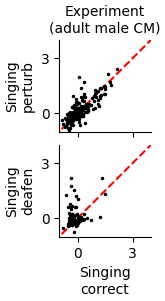

In [154]:
fig, ax = plt.subplots(2, figsize=(3, 3), sharex='all')
ax[0].plot(z_correct, z_pert, '.', ms=3, color='k')
ax[1].plot(z_predeaf, z_postdeaf, '.', ms=3, color='k')
for i, l in enumerate(['Singing\nperturb', 'Singing\ndeafen']):
    ax[i].plot([-3,6], [-3,6], c='r', ls='--', zorder=-1)
    ax[i].set(xlim=[-1,4], ylim=[-1,4], xticks=[0,3], yticks=[0,3], 
              ylabel=l)
    ax[i].set_rasterization_zorder(0)
    ax[i].axes.set_aspect('equal')
ax[0].set_title('Experiment\n(adult male CM)')
ax[-1].set(xlabel='Singing\ncorrect')
fig.savefig('svg/joint_dist_c_vs_nc_experiment.svg', bbox_inches='tight', dpi=300)

0.006419725713644691


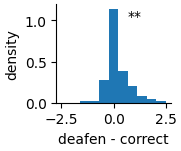

In [155]:
from scipy.stats import wilcoxon
fig, ax = plt.subplots(1, figsize=(1.8, 1.5), sharex='all', sharey='all')
diff = z_postdeaf - z_predeaf
pval = wilcoxon(diff, alternative='greater').pvalue
print(pval)
# ax.plot([1,2], [z_predeaf, z_postdeaf], c='k', alpha=0.1)
# ax.boxplot([z_predeaf, z_postdeaf])
# ax.hist([z_postdeaf, z_predeaf], bins=11, histtype='stepfilled', alpha=0.8)
ax.hist(diff, bins=11, range=(-2.5, 2.5), density=True)
ax.text(1, 1, '**', ha='center')
ax.set(xlabel='deafen - correct', ylabel='density')
fig.savefig('svg/deaf_diff_experiment.svg')